# Spooky_Author_Classification Project

Name: Gloria Gao

<a id='introduction'></a>
## Introduction

I will be using Kaggle [Spooky author](https://www.kaggle.com/c/spooky-author-identification) data for this analysis. In this notebook,I will try to create different features that will help us in identifying the spooky authors.

As a first step, we will do some basic data visualization and cleaning before we delve deep into the feature engineering part.

### [Part 1: Load Data:](#question1)
> The competition dataset contains text from works of fiction written by spooky authors of the public domain. The objective is to accurately identify the author of the sentences in the test set.

> * Edgar Allan Poe (EAP)
> * HP Lovecraft (HPL)
> * Mary Wollstonecraft Shelley (MWS)

### [Part 2: EDA](#question2)
>  Feature Engineering -- This consists of two main parts.

> * Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
> * Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

> Meta Features -- We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:

> * Number of words in the text
> * Number of unique words in the text
> * Number of characters in the text
> * Number of stopwords
> * Number of punctuations
> * Number of upper case words
> * Number of title case words
> * Average length of the words


### [Part 3: Classification Modeling](#question3)
> * Use bagging and boosting models as classifiers 
> * Define softmax metric as multi-class loss function
> * Use GridSearch to do cross-validation and tune parameter.




In [2]:
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
os.getcwd()
# os.chdir("/Users/Desktop/Kaggle")

'/kaggle/working'

<a id='question1'></a>
## Part 1: Load Data
[*Return to Introduction*](#introduction)
> The competition dataset contains text from works of fiction written by spooky authors of the public domain. The objective is to accurately identify the author of the sentences in the test set.

> * Edgar Allan Poe (EAP)
> * HP Lovecraft (HPL)
> * Mary Wollstonecraft Shelley (MWS)
### Acquire and load data

In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


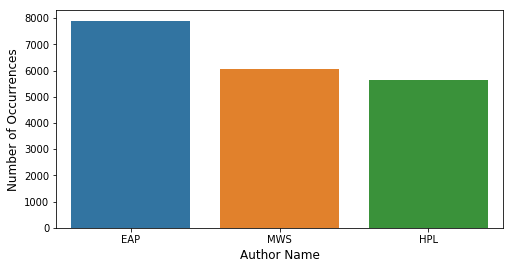

In [5]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [6]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

<a id='question2'></a>
## Part 2: EDA
[*Return to Introduction*](#introduction)
>  Feature Engineering -- This consists of two main parts.

> * Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
> * Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

> Meta Features -- We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:

> * Number of words in the text
> * Number of unique words in the text
> * Number of characters in the text
> * Number of stopwords
> * Number of punctuations
> * Number of upper case words
> * Number of title case words
> * Average length of the words




In [7]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

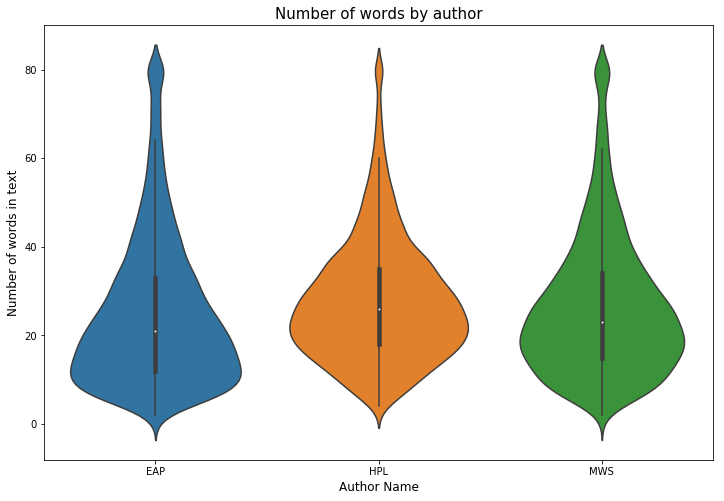

In [8]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

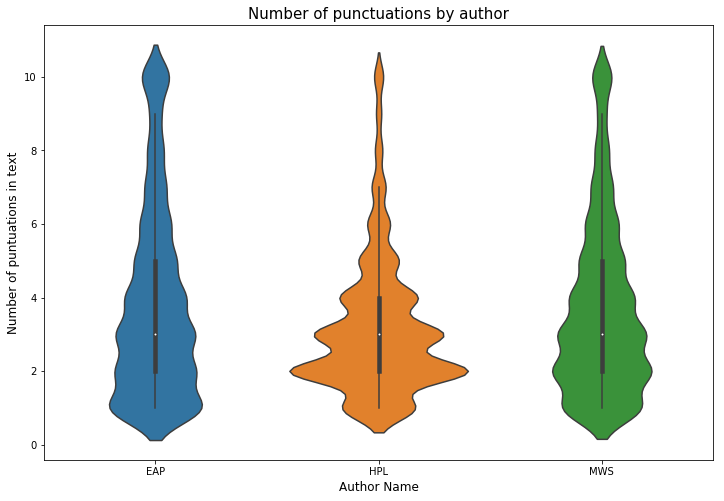

In [9]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [10]:
## Prepare the data for modeling ###
from sklearn.model_selection import train_test_split

author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)

xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.index, train_y, 
                                                  stratify=train_y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)
Xtrain = train_df.iloc[xtrain] # return dataframe Xtrain
Xvalid = train_df.iloc[xvalid]
Ytrain = train_y.iloc[ytrain]
Yvalid = train_y.iloc[yvalid]

train_id = Xtrain['id'].values
test_id = Xvalid['id'].values


### recompute the trauncated variables again ###
Xtrain["num_words"] = Xtrain["text"].apply(lambda x: len(str(x).split()))
Xvalid["num_words"] = Xvalid["text"].apply(lambda x: len(str(x).split()))
Xtrain["mean_word_len"] = Xtrain["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
Xvalid["mean_word_len"] = Xvalid["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
Xtrain = Xtrain.drop(cols_to_drop+['author'], axis=1)
Xvalid = Xvalid.drop(cols_to_drop+['author'], axis=1)

In [11]:
#Always keep these features. They work (almost) everytime!
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing

lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.author.values)
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [12]:
print (Xtrain.shape)
print (Xvalid.shape)

(15663, 8)
(3916, 8)


<a id='question3'></a>
## Part 3: Classification Modeling
[*Return to Introduction*](#introduction)
> GBM reaches best results, then random forest and adaboost.

> * Use bagging and boosting models as classifiers 
> * Define softmax metric as multi-class loss function
> * Use GridSearch to do cross-validation and tune parameter.




In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

In [ ]:
# setup grid searches for c
results_list = list()
param_grids = {'Random Forest': {'n_estimators':[100, 200, 300, 400], 
                      'max_depth':[2,3,4,5,6]},
               'AdaBoost': {'n_estimators':[50, 75, 100], 
                      'learning_rate':[0.001, 0.01, 0.1],
                      'base_estimator':[DecisionTreeClassifier(max_depth=2),
                                        DecisionTreeClassifier(max_depth=3),
                                        DecisionTreeClassifier(max_depth=4)]},
               'Gradient Boosting': {'n_estimators':[25, 50, 75, 100], 
                      'learning_rate':[0.001, 0.01, 0.1, 1.0],
                      'max_depth':[2,3,4,5,6]}}

classifiers = {'Random Forest': RandomForestClassifier(n_jobs=-1, 
                                          random_state=42, 
                                          verbose=0, 
                                          oob_score=True),
              'AdaBoost': AdaBoostClassifier(random_state=42),
              'Gradient Boosting': GradientBoostingClassifier(random_state=42, 
                                              verbose=0)}

# define loss
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return(-1.0 / rows * vsota)


# fit models
for name in ['Random Forest', 'AdaBoost', 'Gradient Boosting']:
    method = classifiers[name]
    grid = GridSearchCV(method, param_grids[name], n_jobs=-1,
                        scoring= 'neg_log_loss')
    grid.fit(Xtrain, Ytrain)
    Ypred = grid.predict_proba(Xvalid)
    log_loss = multiclass_logloss(Yvalid, Ypred, eps=1e-15)  
    df = pd.Series({'name':name, 'grid':grid, 'pred':Ypred, 
                    'Log_loss':log_loss})
    results_list.append(df)

    
    
# compile results
results = pd.concat(results_list, axis=1).T.set_index('name')

# Log_loss
results[['Log_loss']]



#### Text Based Features :
One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.

In [14]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Now that we have got the tfidf vector, here is the tricky part. The tfidf output is a sparse matrix and so if we have to use it with other dense features, we have couple of choices.

>We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, convert it into dense format and concat with other features.

>Build a model using just the sparse features and then use the predictions as one of the features along with other dense features.

Based on the dataset, one might perform better than the other. Here we can use the second approach since there are some very good scoring kernels using all the features of tfidf.

Also it seems that, Naive Bayes is performing better in this dataset. So we could build a naive bayes model using tfidf features as it is faster to train.

In [15]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [16]:
from sklearn import model_selection
from sklearn import ensemble, metrics, model_selection, naive_bayes
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(Xtrain):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8679099074694214


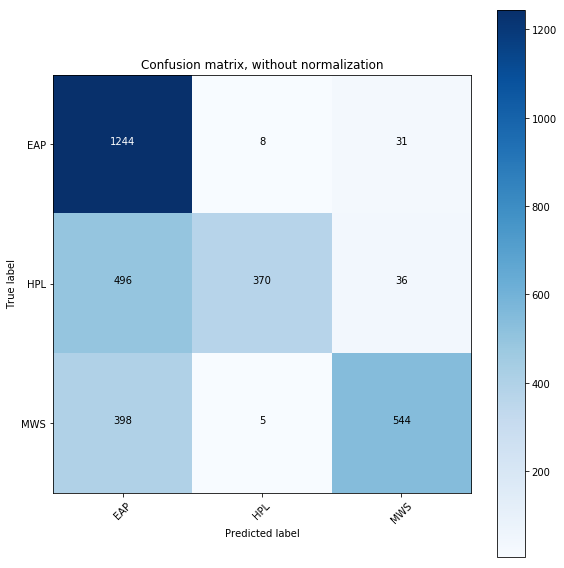

In [17]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

So many instances are predicted as EAP and is highly biased towards that class.

#### SVD on word TFIDF:

Since the tfidf vectors are sparse, one another way of compressing the information and representing it in a much compact way is through SVD. Also generally SVD features have performed well for me in the past text based competitions. So we could created svd features on word tfidf and add them to our feature set.

In [18]:
from sklearn.decomposition import TruncatedSVD
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
# del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [19]:
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [20]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(Xtrain):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.47220771728252553


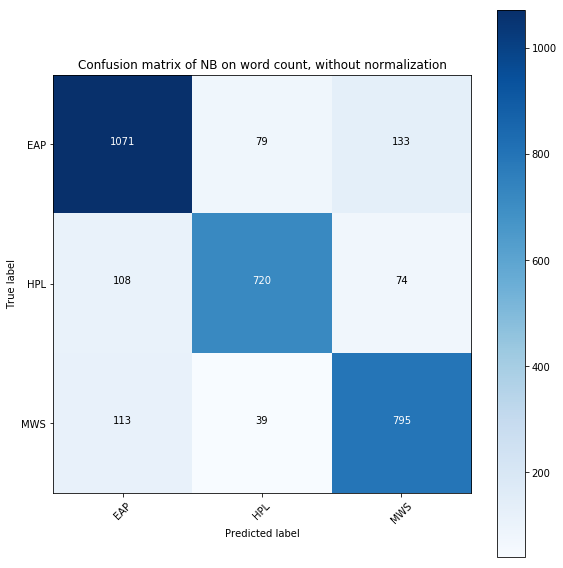

In [22]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()



#### Naive Bayes on Character Count Vectorizer:

One idea from the "data eyeballing" is that counting the special charaters might help. Instead of just counting the special characters, we can use the count vectorizer at character level to get some features. Again we can run Multinomial NB on top of it.

In [23]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(Xtrain):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.905320185025579


The cross val score is very high and is 3.91. But this might add some different information than word level features and so let us use this for the final model as well.

#### Naive Bayes on Character Tfidf Vectorizer:

Let us also get the naive bayes predictions on the character tfidf vectorizer.

In [24]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(Xtrain):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.8692963795226334


#### SVD on Character TFIDF:

We could also create svd features on character tfidf features and used them for modeling.

In [25]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
# del train_tfidf, test_tfidf, train_svd, test_svd

In [26]:
del train_tfidf, test_tfidf, train_svd, test_svd

In [30]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [31]:
import xgboost as xgb
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)

[0]	train-mlogloss:1.02142	test-mlogloss:1.022
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.540789	test-mlogloss:0.551478
[40]	train-mlogloss:0.471439	test-mlogloss:0.491612
[60]	train-mlogloss:0.441507	test-mlogloss:0.471837
[80]	train-mlogloss:0.422162	test-mlogloss:0.461239
[100]	train-mlogloss:0.407805	test-mlogloss:0.45504
[120]	train-mlogloss:0.395608	test-mlogloss:0.451414
[140]	train-mlogloss:0.385194	test-mlogloss:0.447205
[160]	train-mlogloss:0.37566	test-mlogloss:0.444793
[180]	train-mlogloss:0.366224	test-mlogloss:0.442317
[200]	train-mlogloss:0.357479	test-mlogloss:0.439574
[220]	train-mlogloss:0.349834	test-mlogloss:0.43805
[240]	train-mlogloss:0.342313	test-mlogloss:0.435684
[260]	train-mlogloss:0.334731	test-mlogloss:0.433684
[280]	train-mlogloss:0.32735	test-mlogloss:0.432256
[300]	train-mlogloss:0.32036	test-mlogloss:0.431212
[320]	train-mlog

ValueError: Length of values does not match length of index

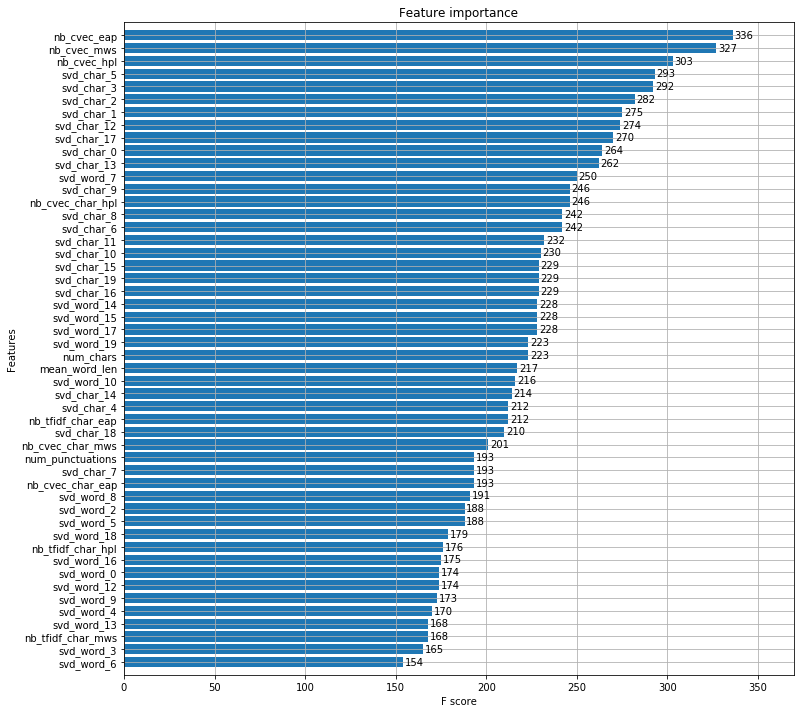

In [32]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

